### To describe the laboratory characteristics of patients in relation to their coronary calcification with binary category

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    balanced_accuracy_score,
)

In [27]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Running on CPU with more than 200 samples may be slow.*",
    category=UserWarning
)

In [28]:
data = pd.read_excel(r"C:\Users\lavan\Downloads\RA_NUIG\datasets\Zero calcium score updated 26 Nov 2025.xlsx", na_values=["", " ", "NA", "N/A"])
data = data.replace(r"^\s*$", pd.NA, regex=True)
#columns hidden on the excel sheet were said to be irrelvant so they were removed
dropcolumns = ["height","weight", "record","reason___3", "reason___4","reason___5","other_symptoms",
               "bp", "systolic_blood_pressure", "diastoic_blood_pressure","hr", "country","mother", 
               "father","language","glucose","random","lip_a_nmol_l", "lipoprotein_a_mg_dl", 
               "laboratory_data_complete","ct___1","ct___2", "contrast","contrast_amount", "radiation",
               "calcification_score","percentile_rank","plaque_burden","clinical_impression",
               "ct_coronary_angiography_complete", "Unnamed: 74", "Unnamed: 75", "Presence of any plaque (yes=1; no=0)",
                "CADrads_classification", "type", "ast" , "ethnicity", "calcium",
                 "type","potassium" ,   #removed since they have 15% missing values
                 "total_daily_dose_10","units_10","frequency_fibra","route_fibra",
                 "total_daily_dose_11","units_11","frequency_nico","route_nico",
               "name_of_drug_12","total_daily_dose_12", "units_12","frequency_cholest","route_chlo",
                 "name_of_drug_13","total_daily_dose_13","units_13","frequency_pcsk9",
                 "route_pcsk9","name_of_drug_14","total_daily_dose_14","units_14",
                 "frequency_rensins","route_rensie","name_of_drug_10", "drug_11", "name_of_statin",
                  "route_statin", "units_9", "frequency_statin", "pcsk9_inhibitors","resins"
                 ,"nicotinic_acid_group", "record.1", "coronary_calcification_score"
#  "coronary_calcification_score","fibrates","nicotinic_acid_group", "cholesterol_absorption", "pcsk9_inhibitors","resins", "statins", "total_daily_dose_9",
       
              ]
data = data.drop(columns=dropcolumns)
print(data.shape)
#print(data.head(50))

#Changing the coding for  calcium score if 0 then Y= 0 , if score > 0 then Y =1
data["Patients with ZERO CALCIUM SCORE (yes=1; no=0)"] = 1 - data["Patients with ZERO CALCIUM SCORE (yes=1; no=0)"].astype(int)
#print(data["Patients with ZERO CALCIUM SCORE (yes=1; no=0)"])

print(data.info())


(794, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 42 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   bmi_cal                                         779 non-null    float64
 1   age                                             794 non-null    int64  
 2   gender                                          794 non-null    int64  
 3   smoking                                         791 non-null    float64
 4   alcohol                                         785 non-null    float64
 5   hypertension                                    792 non-null    float64
 6   hyperlipidemia                                  784 non-null    float64
 7   diabetes                                        790 non-null    float64
 8   family                                          772 non-null    float64
 9   atherosclerosis                  

### Categorizarion of the variables -- Statin, fibrates, cholesterol absorption

In [4]:
statin_code_map = {
    1: "Atorvastatin",
    2: "Fluvastatin",
    3: "Lovastatin",
    4: "Pravastatin",
    5: "Rosuvastatin",
    6: "Simvastatin",
    7: "Pitavastatin",
    8: "None",
    9: "Not Recorded",
    10: "Other",
    11: "Unknown"
}


In [5]:
def get_statin_intensity(statin_type, dose_mg):
    if pd.isna(statin_type) or pd.isna(dose_mg):
        return "NaN"

    dose = float(dose_mg)

    # ----- Atorvastatin -----
    if statin_type == "Atorvastatin":
        if 10 <= dose <= 20: return "Medium"
        if 40 <= dose <= 80: return "High"
        return "NaN"

    # ----- Fluvastatin -----
    if statin_type == "Fluvastatin":
        if 20 <= dose <= 40: return "Low"
        if dose in [40, 80]: return "Medium"
        return "NaN"

    # ----- Lovastatin -----
    if statin_type == "Lovastatin":
        if dose == 20: return "Low"
        if 40 <= dose <= 80: return "Medium"
        return "NaN"

    # ----- Pitavastatin -----
    if statin_type == "Pitavastatin":
        if 1 <= dose <= 4: return "Medium"
        return "NaN"

    # ----- Pravastatin -----
    if statin_type == "Pravastatin":
        if 10 <= dose <= 20: return "Low"
        if 40 <= dose <= 80: return "Medium"
        return "NaN"

    # ----- Rosuvastatin -----
    if statin_type == "Rosuvastatin":
        if 5 <= dose <= 10: return "Medium"
        if 20 <= dose <= 40: return "High"
        return "NaN"

    # ----- Simvastatin -----
    if statin_type == "Simvastatin":
        if dose == 10: return "Low"
        if 20 <= dose <= 40: return "Medium"
        return "NaN"

    return "NaN"


In [6]:
data["statin_type"] = data["statins"].map(statin_code_map)

# Convert dose to numeric
data["statin_dose_mg"] = pd.to_numeric(data["total_daily_dose_9"], errors="coerce")

# Compute intensity
data["statin_intensity"] = data.apply(
    lambda r: get_statin_intensity(r["statin_type"], r["statin_dose_mg"]),
    axis=1
)


In [ ]:
present_fib = {1, 2, 3, 4, 5, 6}

def recode_fibrates(x):
    if pd.isna(x):
        return np.nan
    x = int(x)
    if x in present_fib:
        return 1
    elif x in (0, 7):
        return 0
    else:
        return np.nan

data["fibrates"] = data["fibrates"].apply(recode_fibrates)

present_chol = {1, 3, 4}   # Ezetimibe, Not recorded, Other

def recode_chol_abs(x):
    if pd.isna(x):
        return np.nan
    x = int(x)
    if x in present_chol:
        return 1          # present
    elif x in (2, 5):      # None, Unknown
        return 0
    else:
        return np.nan

data["cholesterol_absorption"] = data["cholesterol_absorption"].apply(recode_chol_abs)


data = data.drop(columns= ["statins","statin_type","statin_dose_mg", "total_daily_dose_9" ] )

In [8]:
print(data.head())

   bmi_cal  age  gender  smoking  alcohol  hypertension  hyperlipidemia  \
0    37.20   64       1      2.0      1.0           1.0             1.0   
1    40.20   63       1      1.0      0.0           1.0             1.0   
2    28.50   71       1      1.0      0.0           1.0             1.0   
3    32.06   67       1      3.0      0.0           1.0             1.0   
4    35.05   51       2      3.0      0.0           1.0             1.0   

   diabetes  family  atherosclerosis  ...     ratio  bilirubin   alt   ggt  \
0       2.0     1.0              1.0  ...  0.176471        6.0  29.0  42.0   
1       2.0     1.0              1.0  ...  0.500000        7.0  12.0  41.0   
2       2.0     1.0              0.0  ...  1.083333        5.0  29.0  80.0   
3       1.0     1.0              1.0  ...       NaN       11.0  31.0  30.0   
4       2.0     1.0              0.0  ...  0.823529        9.0  19.0  29.0   

   chloride  adjusted_calcium  Patients with ZERO CALCIUM SCORE (yes=1; no=0)  \

In [9]:
num_cols = ['bmi_cal', 'age', 'gender','alcohol', 'hypertension', 'hyperlipidemia',
            'diabetes', 'family', 'atherosclerosis', 'pad', 'cad', 'stroke', 'troponin', 'ck', 'hb', 
'wbc', 'plt', 'tc', 'tg', 'hdl', 'ldl', 'hba1c', 'crp', 'egfr', 'creatinine', 'bun', 'sodium', 
'lipoprotein_a', 'apoa', 'apob', 'ratio', 'bilirubin', 'alt', 'ggt', 'chloride', 'adjusted_calcium'] 
 # numeric 
cat_cols = [ 'smoking','statin_intensity', 'fibrates', 'cholesterol_absorption']  #cat


#print(len(num_cols))

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = data.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))


### XGBoost for baseline comparison

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

df = data.copy()

TARGET = "Patients with ZERO CALCIUM SCORE (yes=1; no=0)"  
y = df[TARGET]
X = df.drop(columns=[TARGET])


randomS =42
XtrainVal, Xtest, ytrainVal, ytest = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=randomS
)

Xtrain, Xval, ytrain, yval = train_test_split(
    XtrainVal, ytrainVal, test_size=0.20, stratify=ytrainVal, random_state=randomS
)

print("Train:", Xtrain.shape, "| Val:", Xval.shape, "| Test:", Xtest.shape)


#for col in cat_cols:
#    Xtrain[col] = Xtrain[col].fillna(12)
#    Xtest[col] = Xtest[col].fillna(12)

Train: (508, 41) | Val: (127, 41) | Test: (159, 41)


In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, balanced_accuracy_score


xgb_params = dict(
    objective="binary:logistic", eval_metric="logloss",
    reg_lambda=5, learning_rate=0.05, max_depth=6, n_estimators=100,
    reg_alpha=0, gamma=5, subsample=0.8, colsample_bytree=1.0,
    tree_method="hist", random_state=randomS, n_jobs=-1
)

xgb_model = xgb.XGBClassifier(**xgb_params)


xgb_model.fit(Xtrain, ytrain)


val_pred = xgb_model.predict(Xval)
val_proba = xgb_model.predict_proba(Xval)[:, 1]

# Eval
print(f"XGBoost VAL Accuracy: {accuracy_score(yval, val_pred):.3f}")
print(f"XGBoost VAL AUC: {roc_auc_score(yval, val_proba):.3f}")
print(f"XGBoost VAL PR-AUC: {average_precision_score(yval, val_proba):.3f}")
print(f"XGBoost VAL Balanced Accuracy: {balanced_accuracy_score(yval, val_pred):.3f}")


# Predictions
test_pred = xgb_model.predict(Xtest)
test_proba = xgb_model.predict_proba(Xtest)[:, 1]

# Eval on test set
print(f"XGBoost TEST Accuracy: {accuracy_score(ytest, test_pred):.3f}")
print(f"XGBoost TEST AUC: {roc_auc_score(ytest, test_proba):.3f}")
print(f"XGBoost TEST PR-AUC: {average_precision_score(ytest, test_proba):.3f}")
print(f"XGBoost TEST Balanced Accuracy: {balanced_accuracy_score(ytest, test_pred):.3f}")


XGBoost VAL Accuracy: 0.748
XGBoost VAL AUC: 0.813
XGBoost VAL PR-AUC: 0.823
XGBoost VAL Balanced Accuracy: 0.749
XGBoost TEST Accuracy: 0.686
XGBoost TEST AUC: 0.733
XGBoost TEST PR-AUC: 0.744
XGBoost TEST Balanced Accuracy: 0.685


In [16]:
from tabpfn import TabPFNClassifier
tabpfn_model = TabPFNClassifier()

tabpfn_model.fit(Xtrain, ytrain)

# Predictions
val_proba = tabpfn_model.predict_proba(Xval)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

# Evaluation 
print(f"TabPFN VAL Accuracy: {accuracy_score(yval, val_pred):.3f}")
print(f"TabPFN VAL AUC: {roc_auc_score(yval, val_proba):.3f}")
print(f"TabPFN VAL PR-AUC: {average_precision_score(yval, val_proba):.3f}")
print(f"TabPFN VAL Balanced Accuracy: {balanced_accuracy_score(yval, val_pred):.3f}")

# Predictions test set
test_proba = tabpfn_model.predict_proba(Xtest)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

# Evaluation test set
print(f"TabPFN TEST Accuracy: {accuracy_score(ytest, test_pred):.3f}")
print(f"TabPFN TEST AUC: {roc_auc_score(ytest, test_proba):.3f}")
print(f"TabPFN TEST PR-AUC: {average_precision_score(ytest, test_proba):.3f}")
print(f"TabPFN TEST Balanced Accuracy: {balanced_accuracy_score(ytest, test_pred):.3f}")


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


TabPFN VAL Accuracy: 0.756
TabPFN VAL AUC: 0.833
TabPFN VAL PR-AUC: 0.863
TabPFN VAL Balanced Accuracy: 0.756
TabPFN TEST Accuracy: 0.686
TabPFN TEST AUC: 0.751
TabPFN TEST PR-AUC: 0.762
TabPFN TEST Balanced Accuracy: 0.685


In [17]:
from tabicl import TabICLClassifier

tabicl_model = TabICLClassifier()
tabicl_model.fit(Xtrain, ytrain)

# Predictions
val_proba = tabicl_model.predict_proba(Xval)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

# Evaluation 

print(f"TabICL VAL Accuracy: {accuracy_score(yval, val_pred):.3f}")
print(f"TabICL VAL AUC: {roc_auc_score(yval, val_proba):.3f}")
print(f"TabICL VAL PR-AUC: {average_precision_score(yval, val_proba):.3f}")
print(f"TabICL VAL Balanced Accuracy: {balanced_accuracy_score(yval, val_pred):.3f}")

# Predictions test set
test_proba = tabicl_model.predict_proba(Xtest)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

# Evaluation on test set
print(f"TabICL  TEST Accuracy: {accuracy_score(ytest, test_pred):.3f}")
print(f"TabICL TEST AUC: {roc_auc_score(ytest, test_proba):.3f}")
print(f"TabICL TEST PR-AUC: {average_precision_score(ytest, test_proba):.3f}")
print(f"TabICL  TEST Balanced Accuracy: {balanced_accuracy_score(ytest, test_pred):.3f}")


TabICL VAL Accuracy: 0.748
TabICL VAL AUC: 0.819
TabICL VAL PR-AUC: 0.824
TabICL VAL Balanced Accuracy: 0.749
TabICL  TEST Accuracy: 0.642
TabICL TEST AUC: 0.729
TabICL TEST PR-AUC: 0.751
TabICL  TEST Balanced Accuracy: 0.641


#### Transformer : TabDPT style model

In [19]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 30
patience = 5

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


#There are NO NaNs for PyTorch -- transformer can't handle missingness


Xtrain_f = Xtrain.fillna(0)
Xval_f   = Xval.fillna(0)
Xtest_f  = Xtest.fillna(0)


class TabDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, np.ndarray):
            self.X = X.astype(np.float32)
        else:
            self.X = X.to_numpy().astype(np.float32)
        self.y = np.array(y).astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabDataset(Xtrain_f, ytrain)
val_ds   = TabDataset(Xval_f, yval)
test_ds  = TabDataset(Xtest_f, ytest)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [20]:

# model

class TabDPTTransformer(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1,
        num_classes=2,
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B = x.size(0)
        feat = self.input_proj(x).unsqueeze(1)   # (B,1,d_model)
        cls  = self.cls_token.expand(B, -1, -1)  # (B,1,d_model)
        tokens = torch.cat([cls, feat], dim=1)   # (B,2,d_model)
        enc = self.encoder(tokens)
        cls_out = enc[:, 0, :]
        cls_out = self.norm(cls_out)
        logits = self.head(cls_out)
        return logits

input_dim = Xtrain_f.shape[1]
model = TabDPTTransformer(input_dim=input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:

# train/eval set

def run_epoch(model, loader, train=False):
    if train:
        model.train()
    else:
        model.eval()

    all_probs, all_preds, all_targets = [], [], []
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)

        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # metrics
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except ValueError:
        auc = np.nan
    try:
        pr_auc = average_precision_score(all_targets, all_probs)
    except ValueError:
        pr_auc = np.nan

    acc = accuracy_score(all_targets, all_preds)
    bal_acc = balanced_accuracy_score(all_targets, all_preds)
    avg_loss = total_loss / len(loader.dataset)

    return {
        "loss": avg_loss,
        "auc": auc,
        "pr_auc": pr_auc,
        "acc": acc,
        "bal_acc": bal_acc,
    }


#  training loop with safe early stopping

best_state = None
best_val_metrics = None
best_val_score = -1
pat = 0

for ep in range(1, epochs + 1):
    train_metrics = run_epoch(model, train_loader, train=True)
    val_metrics   = run_epoch(model, val_loader, train=False)

    print(
        f"Epoch {ep:02d} | "
        f"train loss {train_metrics['loss']:.4f} auc {train_metrics['auc']:.3f} | "
        f"val loss {val_metrics['loss']:.4f} auc {val_metrics['auc']:.3f}"
    )

    # prefer AUC, fallback to accuracy
    val_score = val_metrics["auc"]
    if np.isnan(val_score):
        val_score = val_metrics["acc"]

    if val_score > best_val_score:
        best_val_score = val_score
        best_val_metrics = val_metrics
        best_state = model.state_dict()
        pat = 0
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping")
            break

# load best
if best_state is not None:
    model.load_state_dict(best_state)




Epoch 01 | train loss 0.8375 auc 0.539 | val loss 0.6882 auc 0.570
Epoch 02 | train loss 0.7010 auc 0.538 | val loss 0.7040 auc 0.567
Epoch 03 | train loss 0.6803 auc 0.581 | val loss 0.7124 auc 0.575
Epoch 04 | train loss 0.6845 auc 0.570 | val loss 0.7276 auc 0.581
Epoch 05 | train loss 0.6785 auc 0.608 | val loss 0.7139 auc 0.588
Epoch 06 | train loss 0.6792 auc 0.594 | val loss 0.7078 auc 0.590
Epoch 07 | train loss 0.6695 auc 0.625 | val loss 0.7285 auc 0.607
Epoch 08 | train loss 0.6747 auc 0.603 | val loss 0.6907 auc 0.620
Epoch 09 | train loss 0.6581 auc 0.650 | val loss 0.7112 auc 0.630
Epoch 10 | train loss 0.6548 auc 0.645 | val loss 0.6926 auc 0.652
Epoch 11 | train loss 0.6382 auc 0.686 | val loss 0.6855 auc 0.680
Epoch 12 | train loss 0.6274 auc 0.694 | val loss 0.6684 auc 0.720
Epoch 13 | train loss 0.6579 auc 0.668 | val loss 0.7237 auc 0.691
Epoch 14 | train loss 0.6612 auc 0.648 | val loss 0.7130 auc 0.680
Epoch 15 | train loss 0.6328 auc 0.705 | val loss 0.7276 auc 0

In [22]:
# VAL + TEST

if best_val_metrics is not None:
    print(f"\nTabDPT-style VAL Accuracy: {best_val_metrics['acc']:.3f}")
    print(f"TabDPT-style VAL AUC: {best_val_metrics['auc']:.3f}")
    print(f"TabDPT-style VAL PR-AUC: {best_val_metrics['pr_auc']:.3f}")
    print(f"TabDPT-style VAL Balanced Accuracy: {best_val_metrics['bal_acc']:.3f}")
else:
    print("No valid validation metrics were recorded.")

test_metrics = run_epoch(model, test_loader, train=False)
print(f"\nTabDPT-style TEST Accuracy: {test_metrics['acc']:.3f}")
print(f"TabDPT-style TEST AUC: {test_metrics['auc']:.3f}")
print(f"TabDPT-style TEST PR-AUC: {test_metrics['pr_auc']:.3f}")
print(f"TabDPT-style TEST Balanced Accuracy: {test_metrics['bal_acc']:.3f}")



TabDPT-style VAL Accuracy: 0.685
TabDPT-style VAL AUC: 0.765
TabDPT-style VAL PR-AUC: 0.760
TabDPT-style VAL Balanced Accuracy: 0.689

TabDPT-style TEST Accuracy: 0.604
TabDPT-style TEST AUC: 0.722
TabDPT-style TEST PR-AUC: 0.687
TabDPT-style TEST Balanced Accuracy: 0.598


### Plots:
 1. ROC curve 
 2. Precision recall curve
 3. Calibration plot

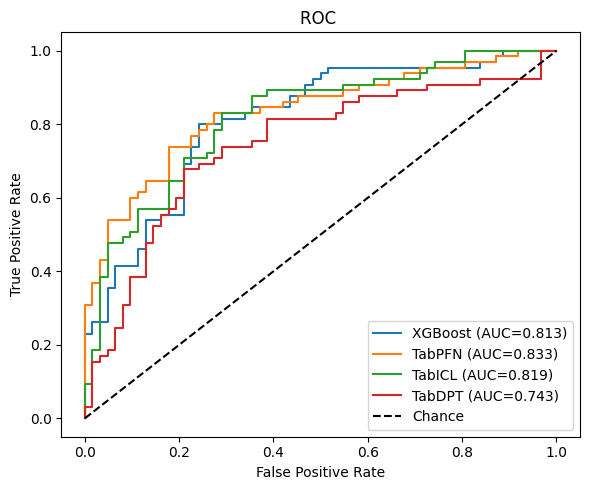

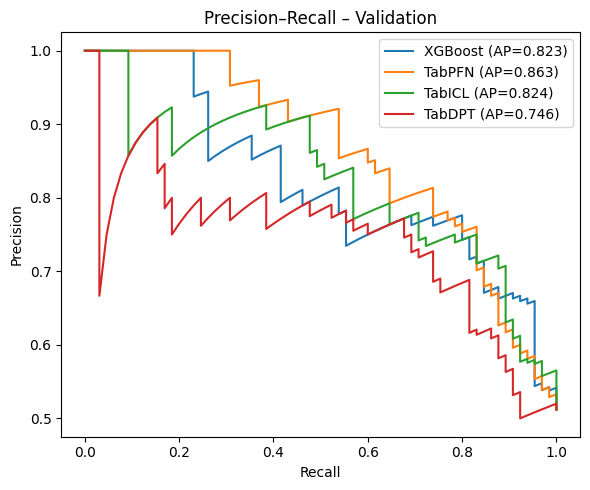

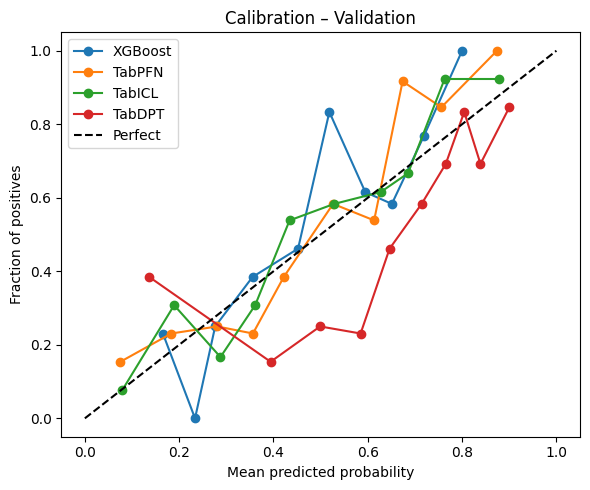

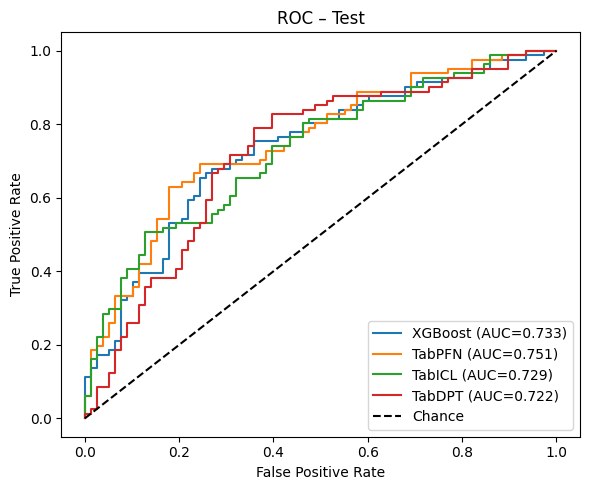

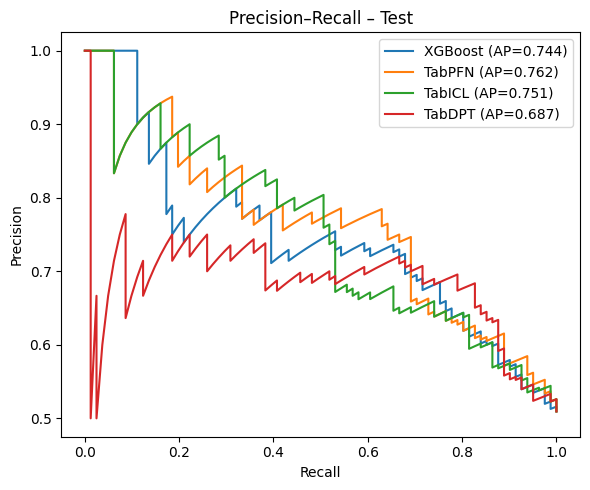

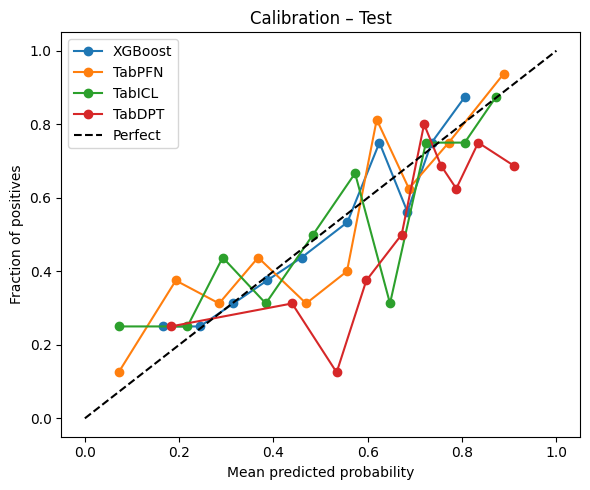

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
)
from sklearn.calibration import calibration_curve

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# helper for the PyTorch TabDPT model (called `model`)
def get_tabdpt_proba(model, X):
    model.eval()
    if not isinstance(X, np.ndarray):
        Xn = X.to_numpy().astype(np.float32)
    else:
        Xn = X.astype(np.float32)
    X_tensor = torch.from_numpy(Xn).to(device)
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
    return probs


# VALIDATION probs (one split, all models)

val_probas = {
    "XGBoost": xgb_model.predict_proba(Xval)[:, 1],
    "TabPFN": tabpfn_model.predict_proba(Xval)[:, 1],
    "TabICL": tabicl_model.predict_proba(Xval)[:, 1],
    "TabDPT": get_tabdpt_proba(model, Xval_f),   # NaN-free version for transformer
}
val_labels = yval


# TEST probs

test_probas = {
    "XGBoost": xgb_model.predict_proba(Xtest)[:, 1],
    "TabPFN": tabpfn_model.predict_proba(Xtest)[:, 1],
    "TabICL": tabicl_model.predict_proba(Xtest)[:, 1],
    "TabDPT": get_tabdpt_proba(model, Xtest_f),
}
test_labels = ytest

def plot_roc(y_true, probas_dict, title):
    plt.figure(figsize=(6,5))
    for name, proba in probas_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--', label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_pr(y_true, probas_dict, title):
    plt.figure(figsize=(6,5))
    for name, proba in probas_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, proba)
        ap = average_precision_score(y_true, proba)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_calibration(y_true, probas_dict, title):
    plt.figure(figsize=(6,5))
    for name, proba in probas_dict.items():
        frac_pos, mean_pred = calibration_curve(
            y_true, proba, n_bins=10, strategy="quantile"
        )
        plt.plot(mean_pred, frac_pos, marker="o", label=name)
    plt.plot([0,1],[0,1], "k--", label="Perfect")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========== VALIDATION plots ==========
plot_roc(val_labels, val_probas, "ROC ")
plot_pr(val_labels, val_probas, "Precision–Recall – Validation")
plot_calibration(val_labels, val_probas, "Calibration – Validation")

# ========== TEST plots ==========
plot_roc(test_labels, test_probas, "ROC – Test")
plot_pr(test_labels, test_probas, "Precision–Recall – Test")
plot_calibration(test_labels, test_probas, "Calibration – Test")


In [79]:
 
from sklearn.model_selection import train_test_split, StratifiedKFold

y_all = df[TARGET].astype(int).to_numpy()
X_all = df.drop(columns=[TARGET]).apply(pd.to_numeric, errors="coerce")

RANDOM_S = 949
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all, random_state=RANDOM_S
)

print("Train+Val:", X_trainval.shape, "| Test:", X_test.shape)

Train+Val: (635, 40) | Test: (159, 40)


In [80]:

# model factories

xgb_params = dict(
    objective="binary:logistic",
    eval_metric="logloss",
    reg_lambda=5,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=100,
    reg_alpha=0,
    gamma=5,
    subsample=0.8,
    colsample_bytree=1.0,
    tree_method="hist",
    n_jobs=-1,
)

def make_xgb():
    return xgb.XGBClassifier(**xgb_params)

def make_tabpfn():
    return TabPFNClassifier()

def make_tabicl():
    return TabICLClassifier()

model_factories = {
    "XGBoost": make_xgb,
    "TabPFN": make_tabpfn,
    "TabICL": make_tabicl,
    # "TabDPT": make_tabdpt  # to add
}


In [81]:

def metrics_from(y_true, proba, pred):
    return dict(
        acc=accuracy_score(y_true, pred),
        auc=roc_auc_score(y_true, proba),
        pr=average_precision_score(y_true, proba),
        bacc=balanced_accuracy_score(y_true, pred),
    )

def print_mean_std(name, rows):
    arr = {k: np.array([r[k] for r in rows]) for k in rows[0].keys()}
    print(f"\n{name} 5-fold CV (on 80%):")
    print(f"ACC  mean={arr['acc'].mean():.3f}  std={arr['acc'].std():.3f}")
    print(f"AUC  mean={arr['auc'].mean():.3f}  std={arr['auc'].std():.3f}")
    print(f"PR   mean={arr['pr'].mean():.3f}   std={arr['pr'].std():.3f}")
    print(f"Bal  mean={arr['bacc'].mean():.3f} std={arr['bacc'].std():.3f}")

In [82]:
# 5-fold CV on the 80%

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {name: [] for name in model_factories.keys()}

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_trainval, y_trainval), 1):
    X_tr = X_trainval.iloc[tr_idx]
    y_tr = y_trainval[tr_idx]
    X_va = X_trainval.iloc[va_idx]
    y_va = y_trainval[va_idx]

    for name, make_model in model_factories.items():
        model = make_model()

        # no fillna here — X_tr / X_va keep NaNs
        model.fit(X_tr, y_tr)

        proba = model.predict_proba(X_va)[:, 1]
        pred = (proba >= 0.5).astype(int)

        m = metrics_from(y_va, proba, pred)
        cv_results[name].append(m)

        print(
            f"Fold {fold} | {name}: "
            f"AUC {m['auc']:.3f}  PR {m['pr']:.3f}  ACC {m['acc']:.3f}  Bal {m['bacc']:.3f}"
        )

# summarize CV
for name in model_factories.keys():
    print_mean_std(name, cv_results[name])

# -----------------------
# 5) final test on 20%
# -----------------------
print("\n=== FINAL TEST on held-out 20% ===")
for name, make_model in model_factories.items():
    model = make_model()
    # again, keep NaNs
    model.fit(X_trainval, y_trainval)

    test_proba = model.predict_proba(X_test)[:, 1]
    test_pred = (test_proba >= 0.5).astype(int)

    m = metrics_from(y_test, test_proba, test_pred)
    print(
        f"{name} – TEST  ACC {m['acc']:.3f} | AUC {m['auc']:.3f} | "
        f"PR-AUC {m['pr']:.3f} | BalAcc {m['bacc']:.3f}"
    )

Fold 1 | XGBoost: AUC 0.761  PR 0.768  ACC 0.732  Bal 0.731


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Fold 1 | TabPFN: AUC 0.771  PR 0.749  ACC 0.724  Bal 0.724
Fold 1 | TabICL: AUC 0.759  PR 0.732  ACC 0.724  Bal 0.725
Fold 2 | XGBoost: AUC 0.818  PR 0.821  ACC 0.756  Bal 0.757


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Fold 2 | TabPFN: AUC 0.840  PR 0.824  ACC 0.764  Bal 0.764
Fold 2 | TabICL: AUC 0.848  PR 0.847  ACC 0.811  Bal 0.811
Fold 3 | XGBoost: AUC 0.782  PR 0.787  ACC 0.693  Bal 0.693


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Fold 3 | TabPFN: AUC 0.797  PR 0.784  ACC 0.740  Bal 0.739
Fold 3 | TabICL: AUC 0.800  PR 0.784  ACC 0.740  Bal 0.739
Fold 4 | XGBoost: AUC 0.823  PR 0.852  ACC 0.701  Bal 0.701


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Fold 4 | TabPFN: AUC 0.843  PR 0.838  ACC 0.748  Bal 0.747
Fold 4 | TabICL: AUC 0.822  PR 0.821  ACC 0.756  Bal 0.754
Fold 5 | XGBoost: AUC 0.735  PR 0.750  ACC 0.669  Bal 0.670


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Fold 5 | TabPFN: AUC 0.747  PR 0.756  ACC 0.693  Bal 0.693
Fold 5 | TabICL: AUC 0.739  PR 0.761  ACC 0.677  Bal 0.677

XGBoost 5-fold CV (on 80%):
ACC  mean=0.710  std=0.030
AUC  mean=0.784  std=0.033
PR   mean=0.795   std=0.037
Bal  mean=0.710 std=0.031

TabPFN 5-fold CV (on 80%):
ACC  mean=0.734  std=0.024
AUC  mean=0.800  std=0.038
PR   mean=0.790   std=0.036
Bal  mean=0.734 std=0.024

TabICL 5-fold CV (on 80%):
ACC  mean=0.742  std=0.044
AUC  mean=0.794  std=0.040
PR   mean=0.789   std=0.041
Bal  mean=0.741 std=0.044

=== FINAL TEST on held-out 20% ===
XGBoost – TEST  ACC 0.698 | AUC 0.736 | PR-AUC 0.728 | BalAcc 0.698


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


TabPFN – TEST  ACC 0.686 | AUC 0.757 | PR-AUC 0.775 | BalAcc 0.686
TabICL – TEST  ACC 0.711 | AUC 0.760 | PR-AUC 0.771 | BalAcc 0.711


In [24]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


y_all = df[TARGET].astype(int).to_numpy()
X_all = df.drop(columns=[TARGET]).apply(pd.to_numeric, errors="coerce")  # keep NaNs for now

# outer 80/20 split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all, random_state=SEED
)


class TabDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, np.ndarray):
            self.X = X.astype(np.float32)
        else:
            self.X = X.to_numpy().astype(np.float32)
        self.y = np.array(y).astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# model 

class TabDPTTransformer(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1,
        num_classes=2,
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B = x.size(0)
        feat = self.input_proj(x).unsqueeze(1)   # (B,1,d_model)
        cls  = self.cls_token.expand(B, -1, -1)  # (B,1,d_model)
        tokens = torch.cat([cls, feat], dim=1)   # (B,2,d_model)
        enc = self.encoder(tokens)
        cls_out = enc[:, 0, :]
        cls_out = self.norm(cls_out)
        logits = self.head(cls_out)
        return logits


#  train / eval 

def run_epoch(model, loader, criterion, optimizer=None):
    train = optimizer is not None
    if train:
        model.train()
    else:
        model.eval()

    all_probs, all_preds, all_targets = [], [], []
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)

        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # metrics
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except ValueError:
        auc = np.nan
    try:
        pr_auc = average_precision_score(all_targets, all_probs)
    except ValueError:
        pr_auc = np.nan

    acc = accuracy_score(all_targets, all_preds)
    bal_acc = balanced_accuracy_score(all_targets, all_preds)
    avg_loss = total_loss / len(loader.dataset)

    return {
        "loss": avg_loss,
        "auc": auc,
        "pr_auc": pr_auc,
        "acc": acc,
        "bal_acc": bal_acc,
    }


# 5-fold CV on the 80%

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

cv_metrics = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_trainval, y_trainval), 1):
    # get fold data
    X_tr = X_trainval.iloc[tr_idx].fillna(0)
    y_tr = y_trainval[tr_idx]
    X_va = X_trainval.iloc[va_idx].fillna(0)
    y_va = y_trainval[va_idx]

    # datasets/loaders
    train_ds = TabDataset(X_tr, y_tr)
    val_ds   = TabDataset(X_va, y_va)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    # new model per fold
    input_dim = X_tr.shape[1]
    model = TabDPTTransformer(input_dim=input_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_state = None
    best_val_score = -1
    patience = 5
    pat = 0
    epochs = 30

    for ep in range(1, epochs + 1):
        train_metrics = run_epoch(model, train_loader, criterion, optimizer)
        val_metrics   = run_epoch(model, val_loader, criterion, optimizer=None)

        # prefer AUC, fallback to acc
        val_score = val_metrics["auc"]
        if np.isnan(val_score):
            val_score = val_metrics["acc"]

        # print(f"Fold {fold} Epoch {ep:02d} | train loss {train_metrics['loss']:.4f} | val AUC {val_metrics['auc']:.3f}")

        if val_score > best_val_score:
            best_val_score = val_score
            best_state = model.state_dict()
            best_val_metrics = val_metrics
            pat = 0
        else:
            pat += 1
            if pat >= patience:
                # print(f"Fold {fold}: early stopping at epoch {ep}")
                break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    cv_metrics.append(best_val_metrics)
    print(f"Fold {fold} – VAL AUC={best_val_metrics['auc']:.3f} | ACC={best_val_metrics['acc']:.3f} | Bal={best_val_metrics['bal_acc']:.3f}")

# summarize CV
accs  = np.array([m["acc"] for m in cv_metrics])
aucs  = np.array([m["auc"] for m in cv_metrics])
prs   = np.array([m["pr_auc"] for m in cv_metrics])
baccs = np.array([m["bal_acc"] for m in cv_metrics])

print("\nTabDPT-style 5-fold CV (on 80%):")
print(f"ACC  mean={accs.mean():.3f}  std={accs.std():.3f}")
print(f"AUC  mean={aucs.mean():.3f}  std={aucs.std():.3f}")
print(f"PR   mean={prs.mean():.3f}   std={prs.std():.3f}")
print(f"Bal  mean={baccs.mean():.3f} std={baccs.std():.3f}")


# optional: train on full 80% and test on 20%

# PyTorch needs no NaNs
X_tr_full = X_trainval.fillna(0)
X_te_full = X_test.fillna(0)

train_ds_full = TabDataset(X_tr_full, y_trainval)
test_ds       = TabDataset(X_te_full, y_test)

train_loader_full = DataLoader(train_ds_full, batch_size=64, shuffle=True)
test_loader       = DataLoader(test_ds, batch_size=64, shuffle=False)

model = TabDPTTransformer(input_dim=X_tr_full.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_state = None
best_val_score = -1
pat = 0
for ep in range(1, 21):
    
    _ = run_epoch(model, train_loader_full, criterion, optimizer)

# final test
test_metrics = run_epoch(model, test_loader, criterion, optimizer=None)
print("\nTabDPT-style TEST (20% hold-out):")
print(f"Accuracy: {test_metrics['acc']:.3f}")
print(f"AUC: {test_metrics['auc']:.3f}")
print(f"PR-AUC: {test_metrics['pr_auc']:.3f}")
print(f"Balanced Accuracy: {test_metrics['bal_acc']:.3f}")


Fold 1 – VAL AUC=0.649 | ACC=0.567 | Bal=0.572
Fold 2 – VAL AUC=0.765 | ACC=0.669 | Bal=0.672
Fold 3 – VAL AUC=0.803 | ACC=0.701 | Bal=0.696
Fold 4 – VAL AUC=0.576 | ACC=0.465 | Bal=0.475
Fold 5 – VAL AUC=0.653 | ACC=0.598 | Bal=0.599

TabDPT-style 5-fold CV (on 80%):
ACC  mean=0.600  std=0.083
AUC  mean=0.689  std=0.083
PR   mean=0.670   std=0.089
Bal  mean=0.603 std=0.078

TabDPT-style TEST (20% hold-out):
Accuracy: 0.679
AUC: 0.727
PR-AUC: 0.689
Balanced Accuracy: 0.676


In [84]:
import shap
tabpfn = TabPFNClassifier()
tabpfn.fit(X, y)


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


TabPFNClassifier()

In [85]:
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

from tabpfn import TabPFNClassifier
from tabpfn_extensions import interpretability

In [86]:

n_samples_test = min(10, len(Xtest))

# feature names from your dataframe
feature_names = Xtest.columns.tolist()

shap_values = interpretability.shap.get_shap_values(
    estimator=tabpfn_model,                      
    test_x=Xtest.iloc[:n_samples_test],          
    attribute_names=feature_names,
    algorithm="permutation",                     
)

print(shap_values.shape)  


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py

(10, 40, 2)


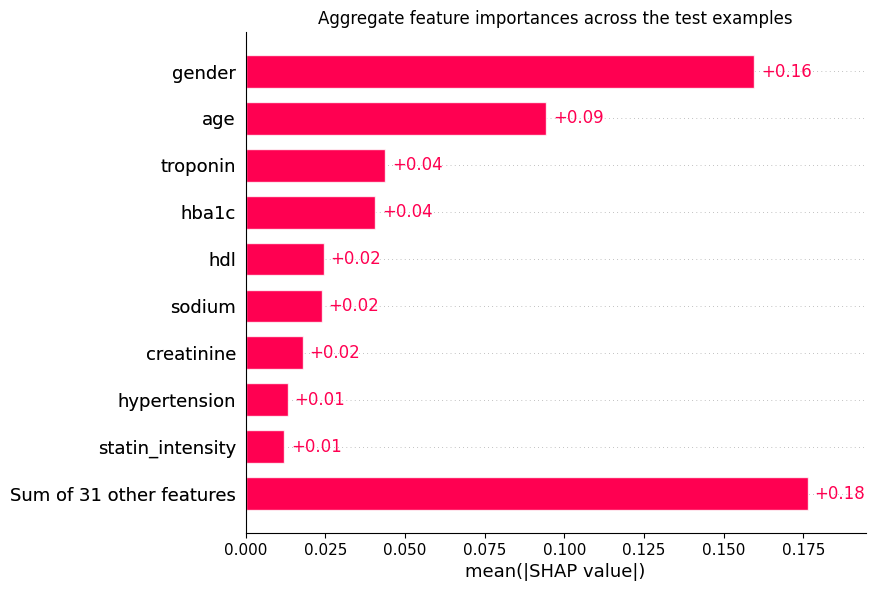

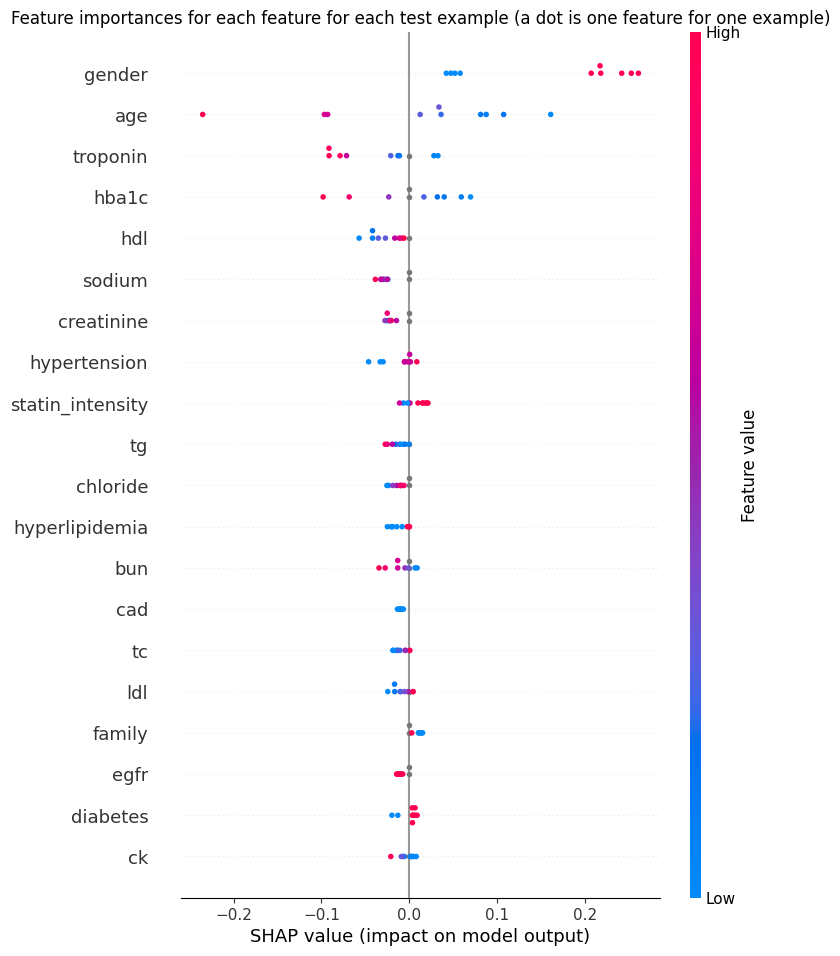

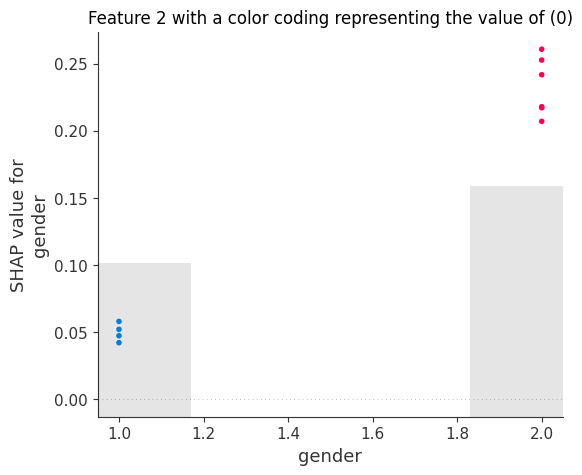

In [87]:
fig = interpretability.shap.plot_shap(shap_values)

In [88]:
top_20_features = ['age', 'gender', 'hypertension', 'hyperlipidemia', 'wbc' ,
                    'troponin', 'ck','plt', 'tc', 'tg', 'hdl', 'ldl', 'hba1c', 
                    'crp', 'alt', 'bun', 'sodium', 'lipoprotein_a', 
                    'apoa', 'apob', 'ratio', 'ggt', 'chloride',
                   'statins'] 


In [89]:
def tabpfn_predict(x):
  
    return tabpfn_model.predict_proba(pd.DataFrame(x, columns=Xval.columns))

import shap
X_shap_subset = Xval.sample(n=10, random_state=42)  

In [90]:
print(type(shap_values))
print(tabpfn_model.predict_proba(X_shap_subset).shape)


<class 'shap._explanation.Explanation'>
(10, 2)


In [91]:
print("Type of shap_values:", type(shap_values))

if isinstance(shap_values, list):
    print("shap_values[1] shape:", shap_values[1].shape)
else:
    print("shap_values shape:", shap_values.shape)

print("X_shap_subset shape:", X_shap_subset.shape)
print("X_shap_subset columns:", len(X_shap_subset.columns))


Type of shap_values: <class 'shap._explanation.Explanation'>
shap_values shape: (10, 40, 2)
X_shap_subset shape: (10, 40)
X_shap_subset columns: 40


  0%|          | 0/10 [00:00<?, ?it/s]

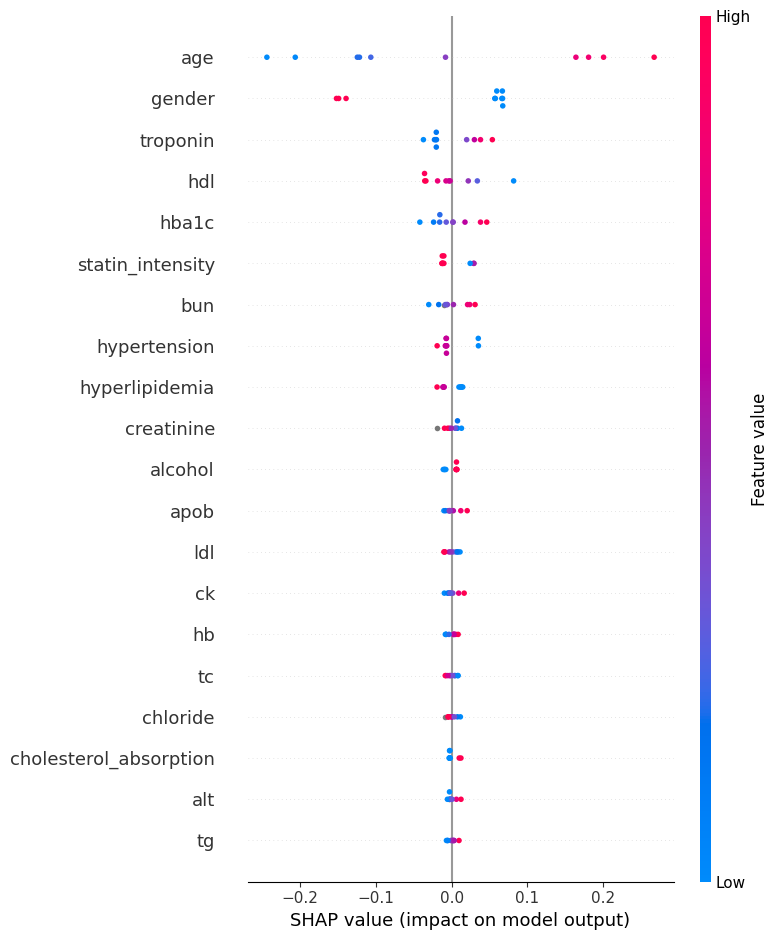

In [92]:
import shap
import pandas as pd

# 1. Prediction wrapper for KernelExplainer
def tabpfn_predict(x):
    return tabpfn_model.predict_proba(pd.DataFrame(x, columns=Xval.columns))

# 2. Select small sample for SHAP
X_shap_subset = Xval.sample(n=10, random_state=42)
background = Xval.sample(n=10, random_state=42)

# 3. Create SHAP KernelExplainer
explainer = shap.KernelExplainer(tabpfn_predict, background)

# 4. Compute SHAP values
shap_values = explainer.shap_values(X_shap_subset)

# 5. Extract class-1 SHAP values
#    Your shap_values shape = (samples, features, classes)
sv = shap_values[:, :, 1]   # class 1 SHAP values

# 6. Plot summary
shap.summary_plot(sv, X_shap_subset)


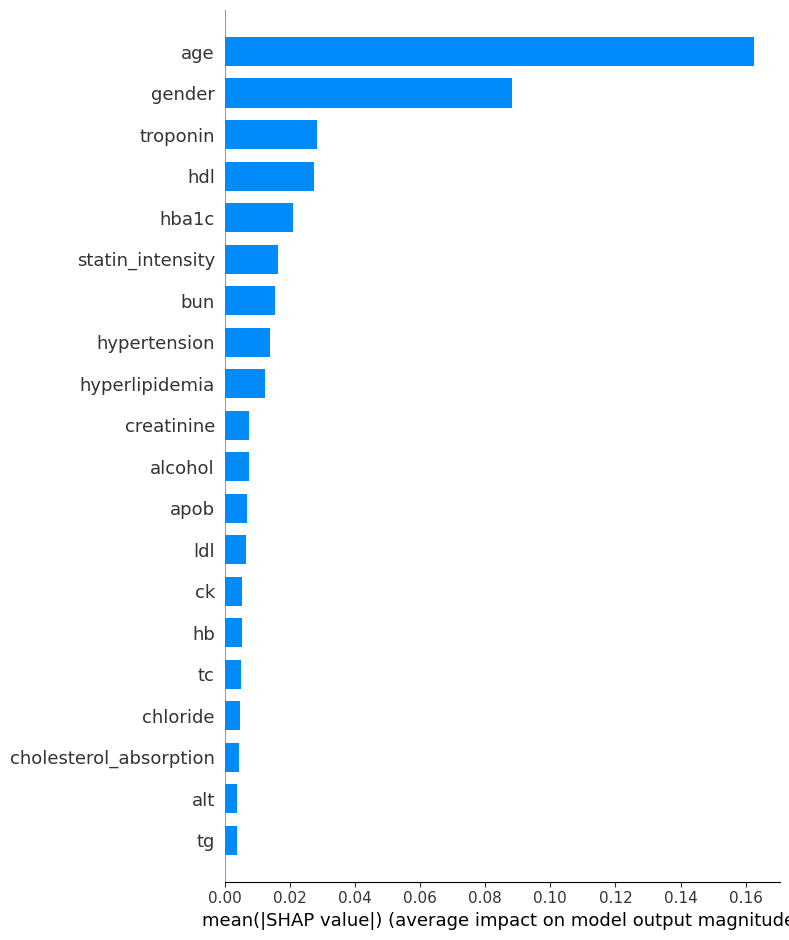

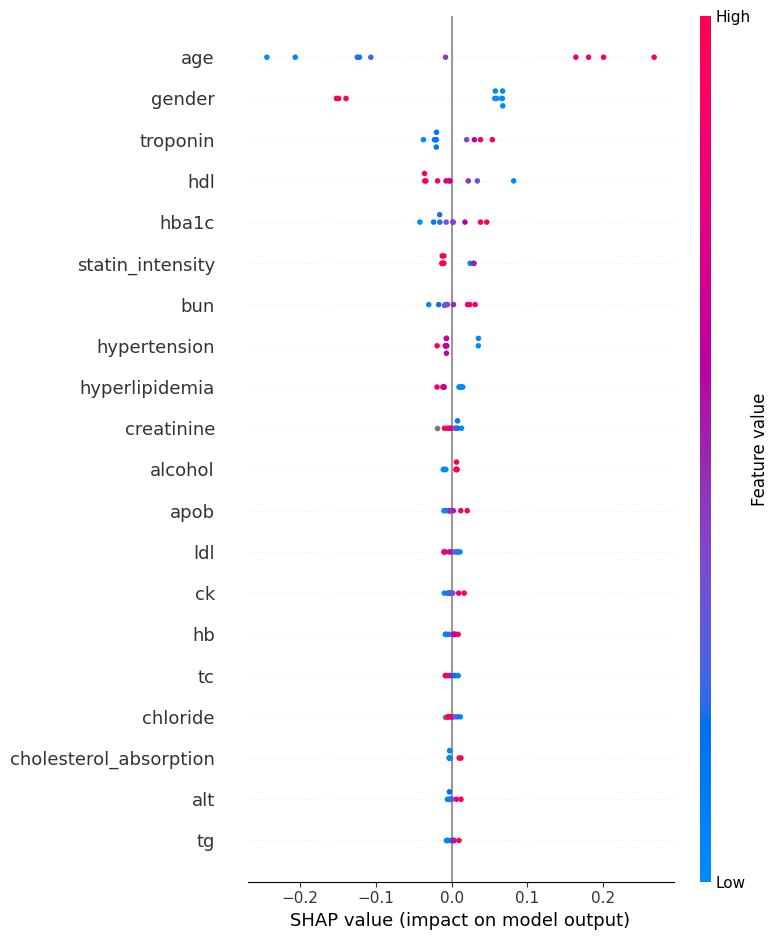

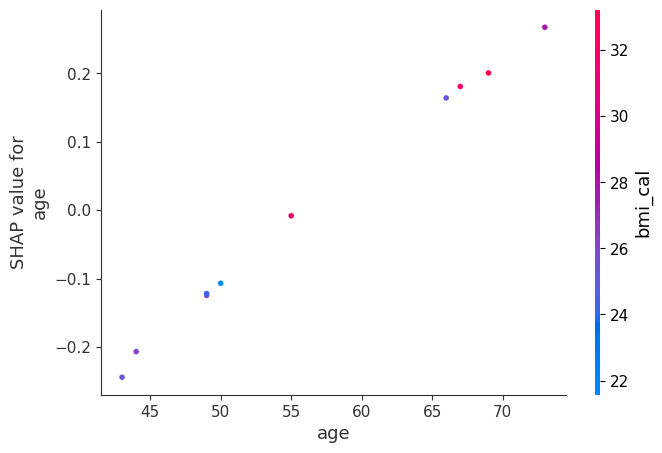

In [93]:

sv = shap_values[:, :, 1]

# 2. Bar plot
shap.summary_plot(sv, X_shap_subset, plot_type="bar")

# 3. Beeswarm
shap.summary_plot(sv, X_shap_subset)

# 4. Dependence plot example
shap.dependence_plot("age", sv, X_shap_subset)




In [94]:
import shap
def fast_predict(x):
    df = pd.DataFrame(x, columns=Xval.columns)
    return tabpfn_model.predict_proba(df)

X_shap_subset = Xval.sample(n=20, random_state=42)

explainer = shap.SamplingExplainer(fast_predict, X_shap_subset)

In [ ]:


# Compute SHAP values
shap_values = explainer.shap_values(X_shap_subset)

# Extract class 1 SHAP values (your shape should be [samples, features, classes])
sv = shap_values[:, :, 1]

# Summary plot
shap.summary_plot(sv, X_shap_subset)

# Bar plot
shap.summary_plot(sv, X_shap_subset, plot_type="bar")


In [96]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    tabpfn_model,
    Xval,
    yval,
    scoring="roc_auc",
    n_repeats=5,
    random_state=42
)

importances = result.importances_mean


<Axes: >

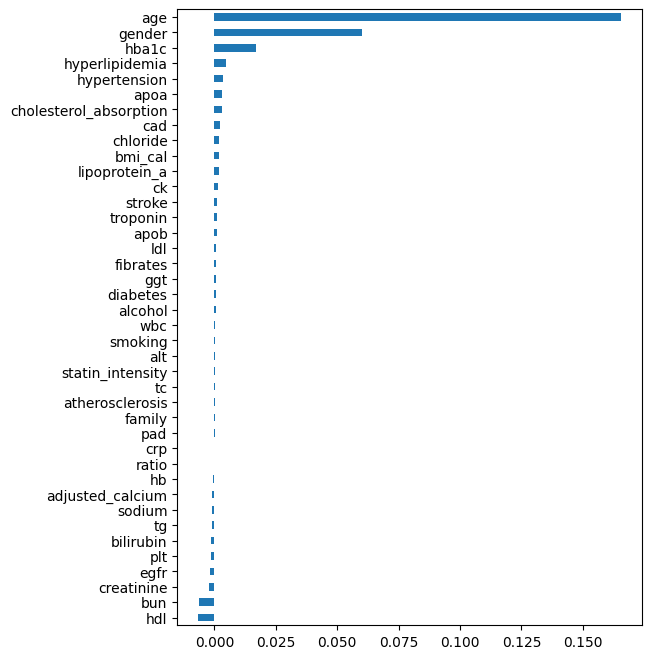

In [97]:
feat_imp = pd.Series(importances, index=Xval.columns)
feat_imp.sort_values().plot(kind="barh", figsize=(6,8))


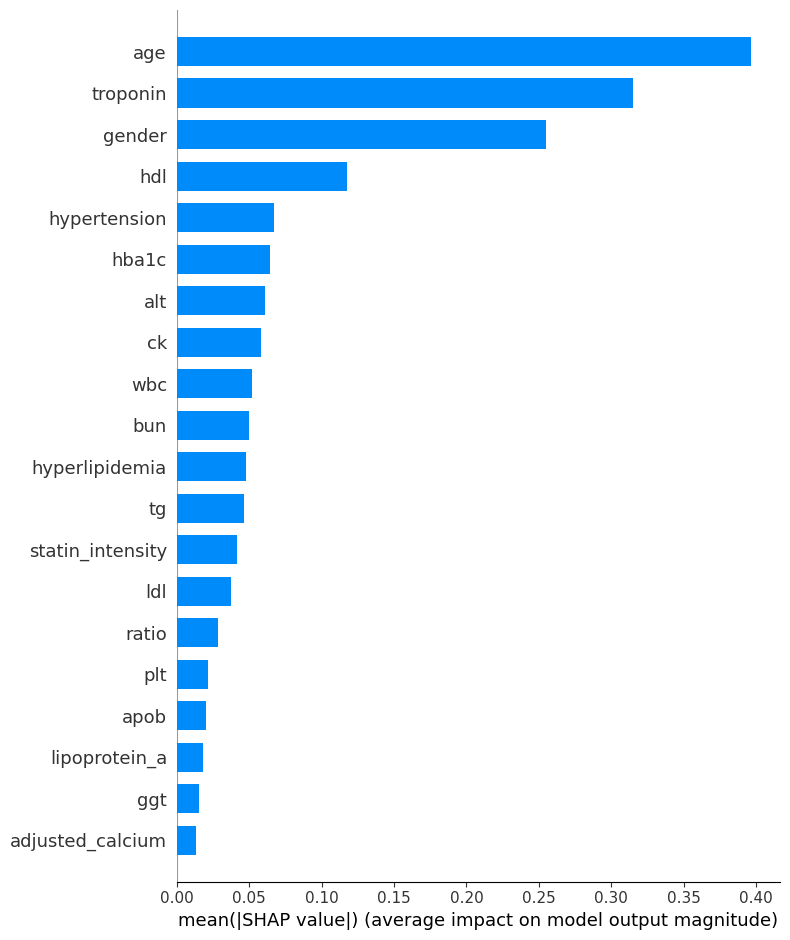

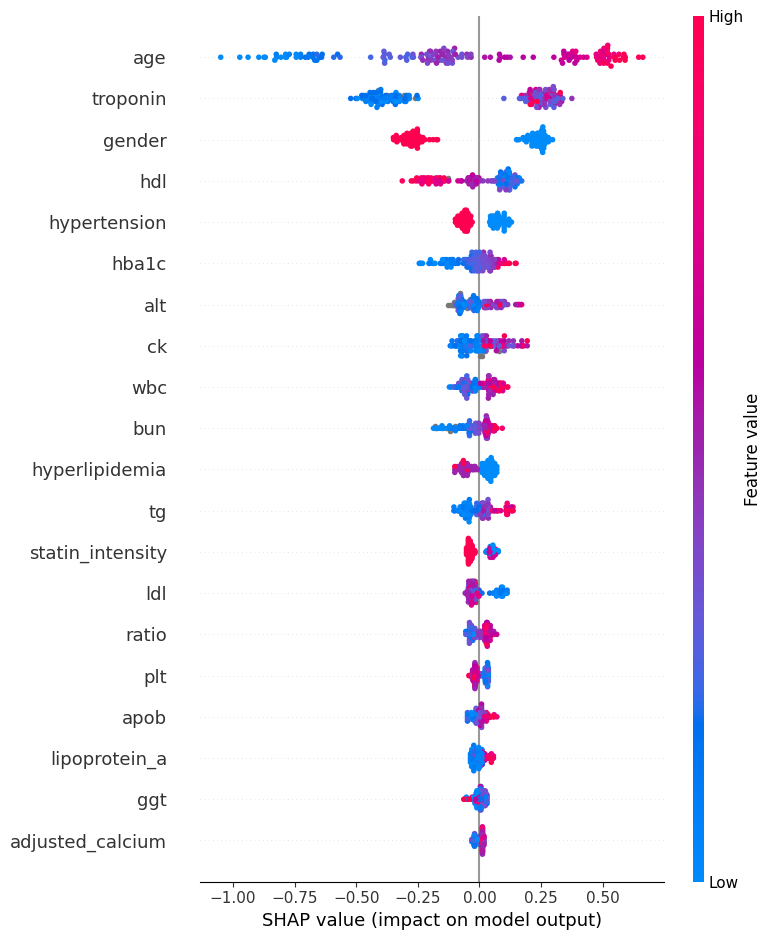

In [98]:
import shap
explainer = shap.Explainer(xgb_model, Xtrain)
shap_values = explainer(Xtest)
shap.summary_plot(shap_values, Xtest, plot_type="bar")
shap.summary_plot(shap_values, Xtest)